In [1]:
import os
from scipy.linalg import svd 
from IPython.core.display import SVG
import pyomo.environ as pyo
import idaes
import idaes.logger as idaeslog
from idaes.core.util.model_statistics import degrees_of_freedom as dof
import idaes.core.util.exceptions as idaes_except
from idaes.core.solvers import use_idaes_solver_configuration_defaults
import idaes.core.util.scaling as iscale
import soec_standalone_flowsheet
from soec_flowsheet_costing import (
    get_solo_soec_capital_costing,
    initialize_flowsheet_costing,
    scale_flowsheet_costing,
    get_soec_OM_costing,
    display_soec_costing
)
import idaes.core.util.model_statistics as mstat
from idaes.models.properties import iapws95
from pyomo.util.check_units import assert_units_consistent
import idaes.core.util as iutil

import numpy as np
import pandas as pd

In [2]:
from pyomo.core.expr.current import identify_variables
from pyomo.common.collections import ComponentSet
def find_active_constraints_containing_variable(var, blk):
    con_set = ComponentSet()
    CUID = pyo.ComponentUID(var)
    for c in blk.component_data_objects(ctype=pyo.Constraint, active=True, descend_into=True):
        for v in identify_variables(c.body):
            if CUID.matches(v):
                con_set.add(c)
    return con_set

In [3]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
idaes.cfg.ipopt.options.OF_ma57_automatic_scaling = "yes"
idaes.cfg.ipopt["options"]["linear_solver"] = "ma57"
idaes.cfg.ipopt["options"]["max_iter"] = 300
idaes.cfg.ipopt["options"]["halt_on_ampl_error"] = "no"

In [4]:
m = pyo.ConcreteModel()
m.fs = soec_standalone_flowsheet.SoecStandaloneFlowsheet(dynamic=False)
iscale.calculate_scaling_factors(m)

2022-12-07 16:40:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-07 16:40:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-07 16:40:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_in[0.0].mole_frac_comp
2022-12-07 16:40:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_out[0.0].mole_frac_comp
2022-12-07 16:40:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-07 16:40:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-07 16:40:23 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flas

In [5]:
m.fs.initialize_build(outlvl=idaeslog.INFO_LOW)#, load_from="soec_standalone_init.json.gz")
# m.fs.initialize_build(outlvl=idaeslog.DEBUG)

2022-12-07 16:40:35 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_in: Starting initialization
2022-12-07 16:40:35 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_in: Property initialization: optimal - Optimal Solution Found.
2022-12-07 16:40:35 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_out: Starting initialization
2022-12-07 16:40:35 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_out: Property initialization: optimal - Optimal Solution Found.
2022-12-07 16:40:35 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side: Initialization Complete
2022-12-07 16:40:35 [INFO] idaes.init.fs.sweep_hot_exchanger.cold_side.properties_in: Starting initialization
2022-12-07 16:40:35 [INFO] idaes.init.fs.sweep_hot_exchanger.cold_side.properties_in: Property initialization: optimal - Optimal Solution Found.
2022-12-07 16:40:35 [INFO] idaes.init.fs.sweep_hot_exchanger.cold_side.properties_out: Starting initialization
2022-12-07 16:40:35 [INFO] idae

In [6]:
print(dof(m))
get_solo_soec_capital_costing(m.fs, CE_index_year="2018")
get_soec_OM_costing(m.fs)
print(dof(m))
iscale.calculate_scaling_factors(m)

0
0
2022-12-07 16:41:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-07 16:41:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-07 16:41:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_in[0.0].mole_frac_comp
2022-12-07 16:41:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_out[0.0].mole_frac_comp
2022-12-07 16:41:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-07 16:41:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-07 16:41:36 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_

In [7]:
solver = pyo.SolverFactory("ipopt")

In [8]:
initialize_flowsheet_costing(m.fs)
scale_flowsheet_costing(m.fs)

m.fs.tags_output["annual_water_cost"] = iutil.ModelTag(
    doc="Annual water cost",
    expr=m.fs.costing.annual_water_cost,
    format_string="{:.2f}",
)

WARNING (W1002): Setting Var 'fs.feed_heater.costing.max_heat_duty' to a
    numeric value `6277258.575732026` outside the bounds (8000000.0, None).
    See also https://pyomo.readthedocs.io/en/latest/errors.html#w1002
WARNING (W1002): Setting Var 'fs.sweep_heater.costing.max_heat_duty' to a
    numeric value `4124693.540929042` outside the bounds (8000000.0, None).
    See also https://pyomo.readthedocs.io/en/latest/errors.html#w1002


In [9]:
assert dof(m) == 0
solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 300, "halt_on_ampl_error":"no"})

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=300
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpkt_0a8fm_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpkt_0a8fm_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
        infeasible point. Problem may be infeasible.


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2498, 'Number of variables': 2498, 'Sense': 'unknown'}], 'Solver': [{'Status': 'warning', 'Message': 'Ipopt 3.13.2\\x3a Converged to a locally infeasible point. Problem may be infeasible.', 'Termination condition': 'infeasible', 'Id': 200, 'Error rc': 0, 'Time': 10.992202758789062}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [10]:
def set_indexed_variable_bounds(var,bounds):
    for idx, subvar in var.items():
        subvar.bounds = bounds
if True:
    m.fs.obj = pyo.Objective(
        expr = (
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.total_annualized_cost
            + m.fs.costing.annual_fixed_operations_and_maintenance_cost
            + m.fs.costing.annual_air_cost
        )
    )
    
    m.fs.max_raw_water_withdrawal_eqn.deactivate()
    m.fs.feed_heater.costing.max_heat_duty_eqn.deactivate()
    m.fs.sweep_heater.costing.max_heat_duty_eqn.deactivate()
    m.fs.heat_pump.costing.max_heat_duty_eqn.deactivate()
    
    m.fs.max_raw_water_withdrawal_ineq.activate()
    m.fs.feed_heater.costing.max_heat_duty_ineq.activate()
    m.fs.sweep_heater.costing.max_heat_duty_ineq.activate()
    m.fs.heat_pump.costing.max_heat_duty_ineq.activate()
    
    for hx in [m.fs.feed_hot_exchanger, m.fs.sweep_hot_exchanger, m.fs.sweep_medium_exchanger,
              m.fs.water_evaporator01, m.fs.water_evaporator02, m.fs.water_evaporator03,
              m.fs.water_evaporator04, m.fs.water_evaporator05, m.fs.water_preheater]:
        set_indexed_variable_bounds(hx.delta_temperature_in, (0, None))
        set_indexed_variable_bounds(hx.delta_temperature_out, (0, None))
        hx.area.bounds = (400, None)
        hx.area.unfix()
    
    for cmp in [m.fs.sweep_blower, m.fs.cmp01, m.fs.cmp02, m.fs.cmp03, m.fs.cmp04]:
        set_indexed_variable_bounds(cmp.work_mechanical, (0, None))
    set_indexed_variable_bounds(m.fs.water_compressor.control_volume.work, (0, None))
    
    m.fs.h2_mass_production.fix(2)
    m.fs.water_preheater.tube_inlet.flow_mol.unfix()
    m.fs.soec_single_pass_water_conversion.unfix()
    m.fs.feed_recycle_split.split_fraction.unfix()
    m.fs.sweep_recycle_split.split_fraction.unfix()
    m.fs.sweep_blower.inlet.flow_mol.unfix()
    #m.fs.sweep_blower.control_volume.properties_out[:].pressure.unfix()
    m.fs.feed_heater.outlet.temperature.unfix()
    m.fs.sweep_heater.outlet.temperature.unfix()
    
    
    
    m.fs.soec_module.potential_cell.unfix()
    m.fs.soec_module.number_cells.unfix()
    m.fs.costing.electricity_price.fix(71.7)
    
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.potential, (1.1,1.6))
    set_indexed_variable_bounds(m.fs.water_split.split_fraction, (0.03,0.98))
    set_indexed_variable_bounds(m.fs.feed_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.sweep_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.heat_pump_hot_terminus.heat_duty, (0, None))
    set_indexed_variable_bounds(m.fs.sweep_blower.inlet.flow_mol,(1000,None))
    m.fs.feed_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    m.fs.sweep_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    set_indexed_variable_bounds(m.fs.soec_overall_water_conversion, (0.4,0.8))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.temperature_z, (550+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.fuel_channel.temperature_inlet, (600+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.oxygen_channel.temperature_inlet, (600+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.current_density, (-10400,5200))
    set_indexed_variable_bounds(m.fs.heat_source.inlet.flow_mol[0], (1, None))
    
    m.fs.feed_heater.costing.max_heat_duty.set_value(8e6)
    m.fs.sweep_heater.costing.max_heat_duty.set_value(8e6)
    #m.fs.heat_pump.costing.max_heat_duty.fix(2e7)
    m.fs.max_raw_water_withdrawal.fix(3000)
    
    for cmp in [m.fs.cmp01, m.fs.cmp02, m.fs.cmp03, m.fs.cmp04]:
        cmp.ratioP.unfix()
        set_indexed_variable_bounds(cmp.ratioP, (1, 3))
        set_indexed_variable_bounds(cmp.outlet.temperature, (273.15, 250+273.15))
    
    m.fs._make_temperature_gradient_terms()
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.fuel_electrode.dtemperature_dz, (-750, 750))
    m.fs.make_performance_constraints()
#     @m.fs.Constraint(m.fs.time)
#     def equal_pressures_eqn(b,t):
#        return b.soec_module.fuel_inlet.pressure[t] == b.soec_module.oxygen_inlet.pressure[t]
    
#     iscale.constraint_scaling_transform(m.fs.equal_pressures_eqn[0],1e-5)

    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from
    C:\Users\cptda\Work\examples-pse\src\Examples\Flowsheets\power_generation\
    standalone_soec\soec_standalone_flowsheet.py:1715)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from
    C:\Users\cptda\Work\examples-pse\src\Examples\Flowsheets\power_generation\
    standalone_soec\soec_standalone_flowsheet.py:1718)


In [11]:
m.fs.h2_mass_production.fix(5)
jac_unscaled, jac_scaled, nlp = iscale.constraint_autoscale_large_jac(m)
solver.solve(m, tee=True, options={"tol": 3e-8, "max_iter": 500, "halt_on_ampl_error":"no"})

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=3e-08
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmp6_qtrlpz_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmp6_qtrlpz_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

  67  5.3961166e+02 2.15e-04 6.08e-02  -5.7 1.04e-01  -0.2 1.00e+00 1.00e+00f  1
  68  5.3960240e+02 3.02e-05 1.28e+00  -5.7 3.91e-02   0.2 1.00e+00 1.00e+00h  1
  69  5.3957433e+02 2.67e-04 3.05e+00  -5.7 1.17e-01  -0.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  5.3956397e+02 3.75e-05 6.07e-02  -5.7 4.40e-02   0.1 1.00e+00 1.00e+00h  1
  71  5.3953255e+02 3.31e-04 3.34e-01  -5.7 1.32e-01  -0.3 1.00e+00 1.00e+00f  1
  72  5.3943840e+02 2.81e-03 3.61e+00  -5.7 3.97e-01  -0.8 1.00e+00 1.00e+00f  1
  73  5.3942682e+02 5.63e-05 6.04e-02  -5.7 5.54e-02   0.0 1.00e+00 1.00e+00h  1
  74  5.3938776e+02 4.87e-04 3.35e+00  -5.7 1.67e-01  -0.4 1.00e+00 1.00e+00f  1
  75  5.3937346e+02 6.81e-05 1.24e+00  -5.7 6.28e-02  -0.0 1.00e+00 1.00e+00h  1
  76  5.3932982e+02 5.94e-04 7.91e-01  -5.7 1.89e-01  -0.5 1.00e+00 1.00e+00f  1
  77  5.3932405e+02 1.18e-05 6.08e-02  -5.7 2.65e-02   0.4 1.00e+00 1.00e+00h  1
  78  5.3930578e+02 1.04e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.3604907e+02 6.15e-02 1.25e+00  -5.7 4.75e-01   0.1 1.00e+00 1.00e+00h  1
 161  5.3604739e+02 2.73e-02 1.08e+03  -5.7 2.74e-01   0.6 3.00e-02 1.00e+00h  1
 162  5.3604656e+02 1.39e-02 7.21e+02  -5.7 1.82e-01   0.1 2.39e-01 7.26e-01h  1
 163  5.3604691e+02 2.38e-03 5.20e+02  -5.7 8.07e-02  -0.4 1.38e-02 1.00e+00h  1
 164  5.3604618e+02 1.32e-03 2.88e+02  -5.7 7.10e-02  -0.9 1.00e+00 4.46e-01h  1
 165  5.3604550e+02 3.49e-05 1.84e-02  -5.7 4.91e-02  -1.3 1.00e+00 1.00e+00h  1
 166  5.3604348e+02 6.34e-03 3.58e+02  -5.7 1.55e-01  -1.8 1.00e+00 6.90e-01h  1
 167  5.3603907e+02 1.42e-03 2.66e+03  -5.7 3.67e-01  -2.3 2.73e-03 1.00e+00f  1
 168  5.3603893e+02 5.27e-04 2.15e+00  -5.7 3.47e-02  -1.0 1.00e+00 1.00e+00h  1
 169  5.3603795e+02 3.59e-03 4.15e+01  -5.7 6.76e-02  -1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  5.3603768e+02 3.22e-03

 251  5.3593145e+02 3.36e-05 1.14e-01  -5.7 1.63e-01  -2.1 1.00e+00 1.00e+00h  1
 252  5.3592913e+02 2.92e-04 1.06e+00  -5.7 4.85e-01  -2.5 1.00e+00 1.00e+00h  1
 253  5.3592243e+02 2.37e-03 1.00e+01  -5.7 1.42e+00  -3.0 1.00e+00 1.00e+00h  1
 254  5.3592251e+02 6.23e-09 4.78e-03  -5.7 4.10e-04   0.5 1.00e+00 1.00e+00h  1
 255  5.3592251e+02 1.84e-09 3.07e-03  -5.7 1.07e-03   0.1 1.00e+00 1.00e+00h  1
 256  5.3592250e+02 1.43e-08 8.64e-03  -5.7 3.52e-03  -0.4 1.00e+00 1.00e+00h  1
 257  5.3592245e+02 1.29e-07 1.34e-03  -5.7 1.06e-02  -0.9 1.00e+00 1.00e+00h  1
 258  5.3592230e+02 1.15e-06 5.17e-03  -5.7 3.16e-02  -1.4 1.00e+00 1.00e+00h  1
 259  5.3592187e+02 1.03e-05 4.47e-02  -5.7 9.48e-02  -1.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  5.3592058e+02 9.10e-05 4.07e-01  -5.7 2.83e-01  -2.3 1.00e+00 1.00e+00h  1
 261  5.3592010e+02 1.26e-05 5.69e-02  -5.7 1.06e-01  -1.9 1.00e+00 1.00e+00h  1
 262  5.3591866e+02 1.12e-04

 344  5.3589448e+02 3.13e-10 1.22e-03  -5.7 8.43e-04   0.2 1.00e+00 1.00e+00h  1
 345  5.3589447e+02 5.40e-09 1.21e-03  -5.7 2.52e-03  -0.3 1.00e+00 1.00e+00h  1
 346  5.3589443e+02 4.86e-08 1.22e-03  -5.7 7.57e-03  -0.8 1.00e+00 1.00e+00h  1
 347  5.3589434e+02 4.37e-07 3.86e-03  -5.7 2.27e-02  -1.3 1.00e+00 1.00e+00h  1
 348  5.3589407e+02 3.91e-06 3.38e-02  -5.7 6.80e-02  -1.7 1.00e+00 1.00e+00h  1
 349  5.3589406e+02 1.19e-09 1.21e-03  -5.7 1.20e-03   0.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  5.3589405e+02 1.09e-08 1.21e-03  -5.7 3.59e-03  -0.5 1.00e+00 1.00e+00h  1
 351  5.3589400e+02 9.78e-08 2.23e-03  -5.7 1.08e-02  -0.9 1.00e+00 1.00e+00h  1
 352  5.3589387e+02 8.78e-07 9.73e-03  -5.7 3.23e-02  -1.4 1.00e+00 1.00e+00h  1
 353  5.3589348e+02 7.85e-06 6.66e-02  -5.7 9.66e-02  -1.9 1.00e+00 1.00e+00h  1
 354  5.3589231e+02 6.91e-05 6.00e-01  -5.7 2.89e-01  -2.4 1.00e+00 1.00e+00h  1
 355  5.3588888e+02 5.85e-04

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2529, 'Number of variables': 2536, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 79.02646398544312}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
m.fs.soec_module.number_cells.pprint()
m.fs.soec_module.solid_oxide_cell.current_density.pprint()
print(pyo.value(m.fs.soec_module.solid_oxide_cell.average_current_density[0]))
print(pyo.value((m.fs.obj)*1e6/(5*m.fs.costing.plant_uptime)))

number_cells : Number of cells in SOC module
    Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1087915.2961570644 :  None : False : False :  Reals
current_density : Size=10, Index=fs.soec_module.solid_oxide_cell.current_density_index, Units=A/m**2
    Key       : Lower  : Value              : Upper : Fixed : Stale : Domain
     (0.0, 1) : -10400 :  -8552.48109987919 :  5200 : False : False :  Reals
     (0.0, 2) : -10400 : -9872.858860532091 :  5200 : False : False :  Reals
     (0.0, 3) : -10400 :           -10400.0 :  5200 : False : False :  Reals
     (0.0, 4) : -10400 : -10146.12766465692 :  5200 : False : False :  Reals
     (0.0, 5) : -10400 :  -9367.40314439785 :  5200 : False : False :  Reals
     (0.0, 6) : -10400 :  -8331.57872852773 :  5200 : False : False :  Reals
     (0.0, 7) : -10400 : -7240.200662219778 :  5200 : False : False :  Reals
     (0.0, 8) : -10400 : -6214.108855194367 :  5200 : False : False :  Re

In [13]:
display_soec_costing(m.fs)

Capital cost: $452M
Fixed O&M cost: $26.6M/yr
Electricity cost: $2.87/kg H2
Water cost: $0.01/kg H2
Air cost: $0.07/kg H2


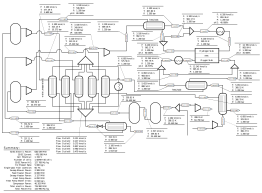

In [14]:
display(SVG(m.fs.write_pfd()))

In [15]:
streams_df = m.fs.streams_dataframe()
display(streams_df)

,mass flow (kg/s),mole flow (kmol/s),mole percent Ar (%),mole percent CO2 (%),mole percent H2 (%),mole percent H2O (%),mole percent N2 (%),mole percent O2 (%),pressure (bar),temperature (K),vapor fraction (%),volumetric flow (m**3/s)
feed01,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,489.184396,100.0,104.510707
feed02a,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,837.804027,100.0,179.843508
feed02b,55.850942,3.100198,NaN,NaN,0.0,100.0,NaN,NaN,1.2,837.804027,NaN,179.816147
feed03,72.020882,6.200397,NaN,NaN,40.000001,59.999999,NaN,NaN,1.2,893.356797,NaN,383.734354
feed04,72.020882,6.200397,NaN,NaN,40.000001,59.999999,NaN,NaN,1.2,929.128108,NaN,399.115451
hstrm01,32.33988,6.200397,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,413.414798
hstrm02,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,206.707403
hstrm03,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,206.707395
hstrm04,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,546.975234,NaN,117.492387
hstrm05,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,399.974765,NaN,85.885427


In [16]:
m.fs.write_pfd(fname="soec_standalone_design_point.svg")
streams_df.to_csv("soec_standalone_design_point.csv")

In [17]:
water_heaters = [
    m.fs.water_evaporator01,
    m.fs.water_evaporator02,
    m.fs.water_evaporator03,
    m.fs.water_evaporator04,
    m.fs.water_evaporator05,
    m.fs.water_preheater,
]
cross_flow_exchangers = [
    m.fs.feed_hot_exchanger,
    m.fs.sweep_hot_exchanger,
    m.fs.sweep_medium_exchanger,
]
heaters = [
    m.fs.feed_heater,
    m.fs.sweep_heater
]
flash_vessels = [m.fs.product_flash01,
                 m.fs.product_flash02,
                 m.fs.product_flash03, m.fs.product_flash04]



compressors = [getattr(m.fs, f"cmp0{i}") for i in range(1,5)]
print(f"Total CapEx: ${pyo.value(m.fs.costing.total_TPC):.2f}MM")
print(f"Contribution from SOEC: ${pyo.value(m.fs.soec_module.costing.total_plant_cost):.2f}MM")
print(f"Contribution from H2 compressors: ${pyo.value(sum([cmp.costing.total_plant_cost for cmp in compressors])):.2f}MM")
print(f"Contribution from H2O compressor: ${pyo.value(m.fs.water_compressor.costing.total_plant_cost):.2f}MM")
print(f"Contribution from trim heaters: ${pyo.value(sum([heater.costing.total_plant_cost for heater in heaters])):.2f}MM")
print(f"Contribution from gas-gas exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in cross_flow_exchangers])):.2f}MM")
print(f"Contribution from gas-water exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in water_heaters])):.2f}MM")
print(f"Contribution from flash vessels: ${pyo.value(sum([flash.costing.total_plant_cost for flash in flash_vessels])):.2f}MM")
print(f"Contribution from heat pump: ${pyo.value(m.fs.heat_pump.costing.total_plant_cost):.2f}MM")
print(f"Contribution from sweep blower: ${pyo.value(m.fs.sweep_blower.costing.total_plant_cost):.2f}MM")
print(f"Contribution from water feed & treatment systems: ${pyo.value(m.fs.costing.water_systems_cost):.2f}MM")
print(f"Contribution from accessory electric equipment: ${pyo.value(m.fs.costing.accessory_electric_plant_cost):.2f}MM")
print(f"Contribution from instrumentation and controls: ${pyo.value(m.fs.costing.instrumentation_and_control_cost):.2f}MM")
print(f"Contribution from improvements to site: ${pyo.value(m.fs.costing.improvements_to_site_cost):.2f}MM")
print(f"Contribution from buildings and structures: ${pyo.value(m.fs.costing.buildings_and_structures_cost):.2f}MM")

print("\n")
print("------------------------------------------")
print("Fixed Costs for Optimized Design")
print("------------------------------------------")

# tpc = pyo.value(m.fs.costing.total_TPC)
# tasc = tpc*1.21*1.093
# ac = tasc*0.0707
assert pyo.value(m.fs.costing.total_TPC) == pytest.approx
print(f"TPC = {pyo.value(m.fs.costing.total_TPC)}")
print(f"TASC = {pyo.value(m.fs.costing.total_as_spent_cost)}")
print(f"Annualized TASC (MM$/yr) = {pyo.value(m.fs.costing.total_annualized_cost)}")

# Parameters
# n_op = 6.3
# hourly_rate = 38.50
# labor_burden = 30

# Fixed O&M components
# annual_op_labor = n_op * hourly_rate * 8760 * (1 - labor_burden/100)/1e6
# maint_labor = tpc * 0.4 * 0.019 
# maint_material = tpc * 0.6 * 0.019
# admin_labor = 0.25*(annual_op_labor + maint_labor)
# prop_tax_ins = 0.02*tpc
# soec_replace = pyo.value(4.2765*m.fs.soec_module.number_cells)/1e6

print("Fixed O&M Costs")
print(f"annual_op_labor (MM$/yr) = {pyo.value(m.fs.costing.annual_operating_labor_cost)}")
print(f"maint_labor (MM$/yr) = {pyo.value(m.fs.costing.maintenance_labor_cost)}")
print(f"maint_material (MM$/yr) = {pyo.value(m.fs.costing.maintenance_material_cost)}")
print(f"admin_labor (MM$/yr) = {pyo.value(m.fs.costing.admin_and_support_labor_cost)}")
print(f"prop_tax_ins (MM$/yr) = {pyo.value(m.fs.costing.property_tax_and_insurance_cost)}")
print(f"soec_replace (MM$/yr) = {pyo.value(m.fs.soec_module.costing.annual_soec_replacement_cost)}")
# total_fixed = annual_op_labor + maint_labor + maint_material + admin_labor + prop_tax_ins + soec_replace
print(f"Annualized Fixed O&M (MM$/year) = {pyo.value(m.fs.costing.annual_fixed_operations_and_maintenance_cost)}")
fixed_cost_per_h2 = pyo.value(
    m.fs.costing.total_annualized_cost
    + m.fs.costing.annual_fixed_operations_and_maintenance_cost
)/24/365.2425/5/60/60*1e6
print(f"Fixed ($/kg h2) = {fixed_cost_per_h2}")

print(f"Annual water cost MM$ {pyo.value(m.fs.costing.annual_water_cost)}")
print(f"water cost $/kg h2 {pyo.value(m.fs.costing.annual_water_cost)/24/365/5/60/60*1e6}")

Total CapEx: $452.40MM
Contribution from SOEC: $72.84MM
Contribution from H2 compressors: $26.30MM
Contribution from H2O compressor: $45.96MM
Contribution from trim heaters: $25.18MM
Contribution from gas-gas exchangers: $16.78MM
Contribution from gas-water exchangers: $43.22MM
Contribution from flash vessels: $0.32MM
Contribution from heat pump: $36.60MM
Contribution from sweep blower: $2.88MM
Contribution from water feed & treatment systems: $31.12MM
Contribution from accessory electric equipment: $93.16MM
Contribution from instrumentation and controls: $23.20MM
Contribution from improvements to site: $27.49MM
Contribution from buildings and structures: $7.35MM


------------------------------------------
Fixed Costs for Optimized Design
------------------------------------------
TPC = 452.3956943737368
TASC = 598.3068776800981
Annualized TASC (MM$/yr) = 42.300296251982935
Fixed O&M Costs
annual_op_labor (MM$/yr) = 2.7639945332999996
maint_labor (MM$/yr) = 3.4382072772403993
maint_ma

In [18]:
for hx in water_heaters + cross_flow_exchangers:
    print(f"{hx.name}: {pyo.value(hx.area)}")

fs.water_evaporator01: 1279.0329661841806
fs.water_evaporator02: 6864.576825569321
fs.water_evaporator03: 1388.3352683580672
fs.water_evaporator04: 5828.030393855516
fs.water_evaporator05: 5206.3233733093575
fs.water_preheater: 842.0490668618233
fs.feed_hot_exchanger: 4639.9174954212185
fs.sweep_hot_exchanger: 5912.261590852149
fs.sweep_medium_exchanger: 8484.387855019084


In [ ]:
for flash in flash_vessels:
    flash.diameter.fix()
    flash.length.fix()
    flash.length_diameter_heuristic.deactivate()
    flash.capacity_heuristic.deactivate()

for hx in water_heaters + cross_flow_exchangers:
    hx.area.fix()

for heater in heaters:
    heater.costing.max_heat_duty.fix()
    
m.fs.soec_module.number_cells.fix()
m.fs.max_raw_water_withdrawal.fix()
m.fs.heat_pump.costing.max_heat_duty.fix()

m.fs.obj.deactivate()
m.fs.obj2 = pyo.Objective(
        expr = (
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.annual_air_cost
        )
    )    

In [ ]:
run_samples = True
df = None
prod_vec = np.linspace(5, 1, 33)

if run_samples:
    i=1
    df = pd.DataFrame(columns=m.fs.tags_output.table_heading())
    for prod in prod_vec:
        print(prod)
        m.fs.h2_mass_production.fix(prod)
        res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 500, "halt_on_ampl_error":"no"})
        assert res.solver.termination_condition == pyo.TerminationCondition.optimal
        assert res.solver.status == pyo.SolverStatus.ok
        df.loc[i] = m.fs.tags_output.table_row(numeric=True)
        i += 1

In [ ]:
m.fs.sweep_heater.report()

In [ ]:
if df is not None:
    df.to_csv("soec.csv")

In [ ]:
display(SVG(m.fs.write_pfd()))

In [ ]:
for flash in [m.fs.product_flash01, 
              #m.fs.product_flash02,
              m.fs.product_flash03, m.fs.product_flash04]:
    print(flash.name)
    print(f"Diameter: {flash.diameter.value}m")
    print(f"Height: {flash.length.value}m")
    print()

In [ ]:
m.fs.soec_module.solid_oxide_cell.temperature_z.pprint()

In [ ]:
print(df)

In [ ]:
pyo.value(m.fs.product_flash01.liq_outlet.flow_mol[0])

In [ ]:
m.fs.sweep_hot_exchanger.report()
pyo.value(m.fs.sweep_hot_exchanger.costing.total_plant_cost)

In [ ]:
m.fs.sweep_hot_exchanger.costing.total_plant_cost.pprint()

In [ ]:
from idaes.core.util.model_diagnostics import DegeneracyHunter
def check_scaling(blk):
    jac, nlp = iscale.get_jacobian(blk, scaled=True)
    # djac = jac.todense()
    # print("Extreme Jacobian entries:")
    # for i in iscale.extreme_jacobian_entries(jac=jac, nlp=nlp, large=1E3, small=0):
    #     print(f"    {i[0]:.2e}, [{i[1]}, {i[2]}]")
    print("Badly scaled variables:")
    for i in iscale.extreme_jacobian_columns(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    print("\n\n" + "Badly scaled constraints:")
    for i in iscale.extreme_jacobian_rows(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    print(f"Jacobian Condition Number: {iscale.jacobian_cond(jac=jac):.2e}")

    if not hasattr(blk, "obj"):
        blk.obj = pyo.Objective(expr=0)
    dh = DegeneracyHunter(blk, solver=pyo.SolverFactory('cbc'))
    dh.check_rank_equality_constraints(dense=True)
    variables = nlp.get_pyomo_variables()
    constraints = nlp.get_pyomo_equality_constraints()
    # ds = dh.find_candidate_equations()
    for i in np.where(abs(dh.v[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + variables[i].name)
    for i in np.where(abs(dh.u[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + constraints[i].name)

    return (variables, constraints, jac, dh)

In [ ]:
variables, constraints, jac, dh = check_scaling(m.fs)

In [ ]:
m.fs.product_flash05.report()

In [ ]:
[j for j, var in enumerate(variables) if var.name == "fs.product_flash01.control_volume.properties_out[0.0].flow_mol_phase[Liq]"]


In [ ]:
col = jac.getcol(1178)

In [ ]:
print(col)

In [ ]:
constraints[1428].name

In [ ]:
jac, nlp = iscale.get_jacobian(m.fs, scaled=True, equality_constraints_only=True)

In [ ]:
jac = jac[0]

In [ ]:
variables = nlp.get_pyomo_variables()
constraints = nlp.get_pyomo_equality_constraints()

In [ ]:
dh.check_residuals(1e3)

In [ ]:
m.fs.sweep_hot_exchanger.report()

In [ ]:
m.fs.sweep_heater.report()

In [ ]:
m.fs.water_evaporator02.report()

In [ ]:
m.fs.soec_module.number_cells.pprint()

In [ ]:
m.fs.feed_hot_exchanger.heat_transfer_equation[0.0].pprint()

In [ ]:
3683.5*100.00*86.961

In [ ]:
import matplotlib.pyplot as plt
soc = m.fs.soec_module.solid_oxide_cell

plt.figure()
plt.plot(np.array(soc.iznodes), np.array(
    [pyo.value(soc.current_density[0, i]) for i in
     soc.iznodes]) / 10, label="Current Density")
plt.plot(np.array(soc.iznodes), np.ones((10, 1)) * sum(
    [pyo.value(soc.current_density[0, i]) for i in
     soc.iznodes]) / 100, "--", label="Average Current Density")

plt.xlabel("z node", fontsize=14)
plt.ylabel(r"Current Density ($mA/cm^2$)", fontsize=14)
plt.title("Current Density", fontsize=16)

plt.figure()
plt.plot(np.array(soc.iznodes), np.array(
    [pyo.value(soc.fuel_triple_phase_boundary.potential_nernst[0, iz]
               + soc.oxygen_triple_phase_boundary.potential_nernst[0, iz])
     for iz in soc.iznodes]),
    label="Nernst Potential"
 )

plt.xlabel("z node", fontsize=14)
plt.ylabel(r"Nernst Potential (V)", fontsize=14)
plt.title("Nernst Potential", fontsize=16)

plt.figure()
plt.plot(np.array(soc.iznodes), np.array(
    [pyo.value(soc.fuel_electrode.temperature[0, 1, i]) for i in
     soc.iznodes]), label="Temperature")
plt.plot(np.array(soc.iznodes), np.ones((10, 1)) * sum(
    [pyo.value(soc.fuel_electrode.temperature[0, 1, i]) for i in
     soc.iznodes]) / 10, "--", label="Average Temperature")

plt.legend()
plt.xlabel("z node", fontsize=14)
plt.ylabel("Temperature (K)", fontsize=14)
plt.title("PEN Temperature", fontsize=16)

plt.figure()
plt.plot(np.array(soc.iznodes), np.array(
    [pyo.value(soc.fuel_electrode.dtemperature_dz[0, 1, i]) for i in
     soc.iznodes])/100)
plt.xlabel("z node", fontsize=14)
plt.ylabel(r"$\frac{dT}{dz}$ (K/cm)", fontsize=14)
plt.title("PEN Temperature Gradient", fontsize=16)

plt.show()

In [ ]:
m.fs.water_withdrawal_system.costing.pprint()

In [ ]:
m.fs.cmp01.work_mechanical.pprint()

In [ ]:
m.fs.heat_pump.pprint()

In [ ]:
m.fs.product_flash02.report()

In [ ]:
pyo.value(m.fs.heat_pump.costing.total_plant_cost)